log(T)


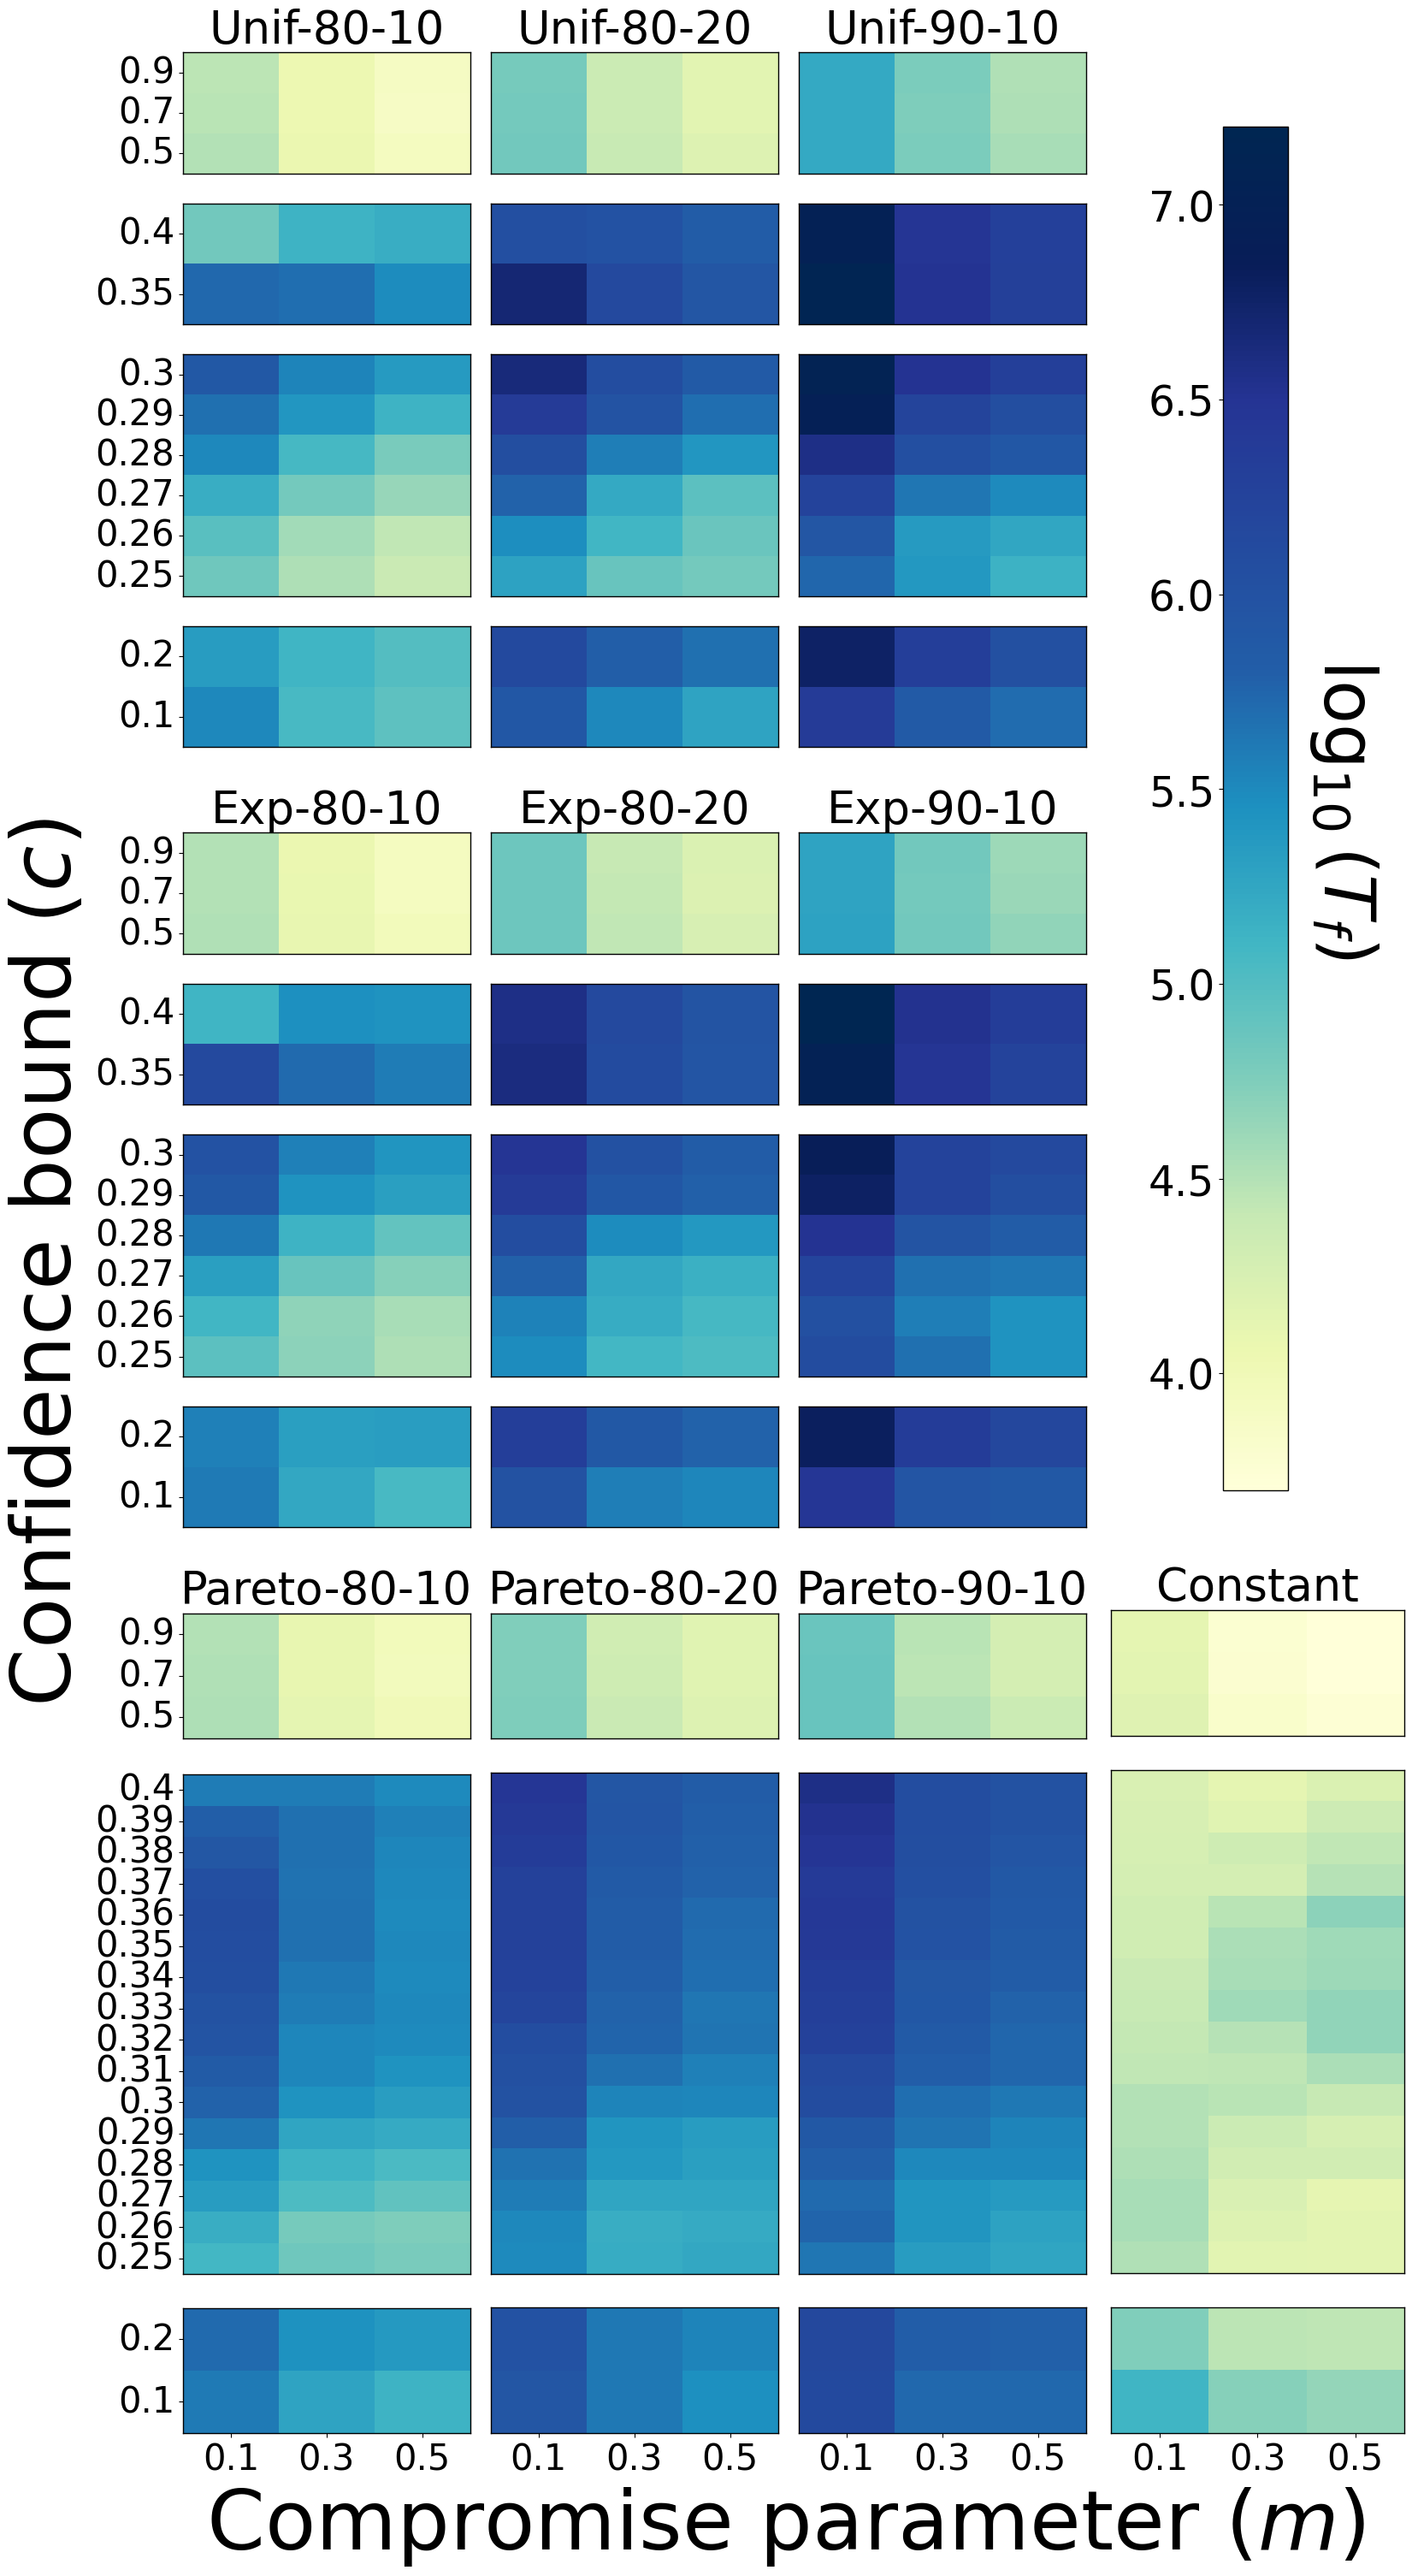

In [1]:
"""
Created on 3/21/2022
Created by Grace Li

This script generates a figure consisting of a grid of heatmaps of the results of the simulations for our DW model with node weights.
There is a large vertical colorbar on the side.

In the paper, we examine the numbers of major and minor clusters, Shannon entropy, mean local receptiveness and convergence time.
Here, we also plot the variance of final opinions and the convergence time in terms of time-steps where opinions changed.

For each quantity of interest, this script generates a figure consisting of a row of heatmaps. Each heatmap represents a single 
distribution of node weights, and has the confidence bound c (named d in the code) on the vertical axis and the compromise 
parameter m (named mu in the code) on the horizontal axis. There is an option to show labels on each cell of the heatmaps 
which can represent the mean value of our simulations +/- one standard deviation. 

We generate each cell in each heatmap from 100 numerical simulations from 10 sets of node weights that each have 10 sets of initial opinions.
We used this script to generate our figures for our simulations of our DW model with node weights for complete graphs, 
For other graphs, see ../Heatmaps.py

"""

# import required packages  

import numpy as np
import pandas as pd
from scipy import io, stats
import os
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import time as time
import igraph as igraph

# Import our own DW module
import sys
sys.path.append('..') #look one directory above
import DW as DW

### Change plot parameters here --------------------------------------------------------------
#name of experiment folder
graph_type = "complete"
n = 500

show_labels = False

print_std = True
default_decimal_places = 2
if show_labels == False:
    print_std = False

print_title = False

distribution_name = ['Uniform', 'Exp', 'Pareto']
distribution_suffix = ["-80-10", "-80-20", "-90-10"]

#Compromise parameter
'''
NOTE: THE COMPROMISE PARAMETER IS CALLED mu HERE, BUT m IN THE PAPER
'''
mus = [0.1, 0.3, 0.5]

#Define quantities of interest
keys = [
        'log(T)', 'log(T_changed)', 
        'entropy',
        'n_minor', 'n_clusters_major',
        'avg_local_receptiveness',
        'op_var'
       ]
keys = ['log(T)']

#Combine the distributions to get all distribution to get the heatmaps of
distributions = ["Constant"]
for name in distribution_name:
    for suffix in distribution_suffix:
        distributions.append(name + suffix)

#Check that a directory exists, and if not, create it
directory = graph_type + str(n) + '/combined_plots/heatmaps/cbar_vertical/' + ('with_title/' * print_title) + ('labeled/' * show_labels)
if not os.path.exists(directory):
    os.makedirs(directory)
    
#Define the confidence bound sections for each distribution
'''
NOTE: THE CONFIDENCE BOUND IS CALLED d HERE, BUT c IN THE PAPER
'''
#The default values and subfigure heights
other_ds = [
            [0.1, 0.2], 
            [0.25, 0.26, 0.27, 0.28, 0.29, 0.3], 
            [0.35, 0.4],
            [0.5, 0.7, 0.9]
         ]
other_subfig_heights = [2, 4, 2, 2]


#d values and subfigure heights for Pareto distribution heatmaps
pareto_ds = [
            [0.1, 0.2], 
            [0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4],
            [0.5, 0.7, 0.9]
         ]
pareto_subfig_heights = [2, 8, 2]

#flip ds so that heatmaps are ordered properly
other_ds = [np.flip(ds) for ds in other_ds]
other_ds.reverse()
other_subfig_heights.reverse()
pareto_ds = [np.flip(ds) for ds in pareto_ds]
pareto_ds.reverse()
pareto_subfig_heights.reverse()

#Width and height ratios of the subfigures
width_ratios = [1.28] + len(distribution_suffix) * [1]
if show_labels:
    width_ratios = [1.25] + len(distribution_suffix) * [1]
height_ratios = [1, 1, sum(pareto_subfig_heights)/sum(other_subfig_heights)]


### Plot parameters -----------------------------------------------------------------------------------------
figsize = (4.1 * (len(distribution_name) + 1), sum(other_subfig_heights) * len(distribution_name) )
fontsizes = {'XXS': 8, 'XS': 20, 'S': 30, 'M': 35, 'L': 38, 'XL': 60, 'XXL': 70}

if show_labels and print_std:
    # figsize = (5.5 * (len(distribution_name) + 1), sum(other_subfig_heights) * len(distribution_name) *0.8)
    figsize = (5.1 * (len(distribution_name) + 1), sum(other_subfig_heights) * len(distribution_name))
    fontsizes = {'XXS': 5.4, 'XS': 14, 'S': 30, 'M': 30, 'L': 38, 'XL': 60, 'XXL': 70}  

border_width = 1
    
base_cmap = "inferno"
reverse_cmpa = "inferno_r"

nodes = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]
colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58', '#002652'] #Yellow green blue
# colors = ['#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a', '#0e0014'] #Red purple
base_cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
colors.reverse() #flip the colors
reverse_cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
colors.reverse() #flip back to the original in case we need them again

#Names for plots and save files
plot_name = {
                # 'log(T)': 'T', 
                'log(T)': 'Tf', 
                'log(T_changed)': 'T_changed',
                'n_clusters': 'clusters', 'entropy' : 'entropy',
                'n_minor' : 'minor_clusters',
                'n_clusters_major' : 'major_clusters',
                'entropy_major' : 'entropy_major',
                'avg_opinion_diff': 'op_diff', 
                'avg_local_agreement' : 'agreement', 
                'avg_local_receptiveness': 'receptiveness',
                'op_mean': 'op_mean', 'op_var': 'op_var', 
                'op_skew': 'op_skew', 'op_kurtosis': 'op_kurtosis'
            }
plot_title = {
                # 'log(T)': r"$\log_{10}(T)$",
                'log(T)': r"$\log_{10}(T_f)$",
                'log(T_changed)': r"$\log_{10}(T_\mathrm{changed})$",
                'n_clusters': 'Number of clusters', 
                'entropy': 'Shannon entropy',
                'n_minor' : 'Number of minor clusters',
                'n_clusters_major' : 'Number of major clusters',
                'entropy_major' : 'Shannon entropy of major clusters',
                'avg_opinion_diff': 'Mean of opinion difference',
                'avg_local_agreement': 'Mean of local agreement', 
                'avg_local_receptiveness': 'Mean of local receptiveness', 
                'op_mean': 'Opinion mean', 'op_var': 'Opinion variance', 
                'op_skew': 'Opinion skew', 'op_kurtosis': 'Opinion kurtosis'
             }



#Statistics to look at
stats = ['avg', 'std']
save_suffix = {'avg':'_avg', 'std':'_std'}
title_prefix = {'avg':'Mean of ', 'std': 'STD of '}
title_prefix = {'avg':'', 'std': 'STD of '}

### Loop through the quantities of interest and generate plots ------------------------------------------
for key in keys:
    print(key)
    
    #Get the decimal place if we're printing labels
    if show_labels:
        decimal_places = default_decimal_places
        if key == 'op_var':
            decimal_places = 3
            
        if key in ['entropy', 'n_minor','op_var'] and not print_std:
            figsize = (5.3 * (len(distribution_name) + 1), sum(other_subfig_heights) * len(distribution_name))
    
    #Pick the colormap based on if we want higher or lower numbers more important
    if key in ['avg_local_receptiveness']: #lower numbers are more important
        cmap = reverse_cmap
    else:
        cmap = base_cmap

    #Get all the heatmap sections for plotting
    heatmaps = {} #dictionary to store the heatmaps for each distribution
    
    for distribution in distributions:
    
        #savefolder name for experiment
        experiment = graph_type + str(n) + "/" + distribution

        #Initialize the dataframe
        filename = experiment + '/combined_matfiles/simulation_results.csv'
        sim_results = pd.read_csv(filename)

        #Make sure the graph, weight_set and opinion_set, and time steps are integers instead of floats
        sim_results = sim_results.astype({'weight_set': int, 'opinion_set': int, 'T': int, 'T_changed': int})

        #Calculate the log of time steps to make it easier to visualize
        sim_results['log(T)'] = np.log10(sim_results['T'])
        sim_results['log(T_changed)'] = np.log10(sim_results['T_changed'])
        
        #Get the corresponding list of confidence bound ds for this distribution
        if distribution[0:5] in ['Paret', 'Const']:
            all_ds = pareto_ds
            subfig_heights = pareto_subfig_heights
        else:
            all_ds = other_ds
            subfig_heights = other_subfig_heights

        #For each segment of the heatmap (a sublist ds in all_ds)
        for section in range(len(all_ds)):
            
            ds = all_ds[section] #Get the confidence bound d values for this section
    
            #Create zero matricies for each heatmap we want to generate
            average, std = np.zeros((len(ds), len(mus))), np.zeros((len(ds), len(mus)))

            #Fill in the heatmap values 
            # rows correspond to d
            for row in range(0,len(ds)):
                d = ds[row]

                # columns correspond to mu
                for col in range(0, len(mus)):
                    mu = mus[col]

                    #filter the data table by the d and mu values
                    df = sim_results[sim_results['d'] == d]
                    df = df[df['mu'] == mu]

                    #Calculate the descriptive stats
                    stats = df[key].describe()

                    #Add the stats values to the appropriate matrix (heatmap)
                    average[row][col] = stats['mean']
                    std[row][col] = stats['std']

            #store the heatmaps
            heatmaps[distribution + str(section)] = {'avg':average, 'std':std}
 

    #Plot the heatmaps
    for stat in ['avg']: #in heatmaps[distribution].keys():
        
        plot_maps = {heatmap_key: heatmaps[heatmap_key][stat] for heatmap_key in heatmaps.keys()} #collect all the heatmaps of the same quantity - i.e. average, std
        
        #Generate the figure and grid of subfigures for each heatmap
        fig = plt.figure( constrained_layout=True, facecolor='white', figsize = figsize )
        parent_subfigs = fig.subfigures(1, 2, width_ratios = [width_ratios[0]+width_ratios[1]+width_ratios[2], width_ratios[3]])
        
        subfigs = parent_subfigs[0].subfigures(len(distribution_name), len(distribution_suffix),
                                    width_ratios = [width_ratios[0],width_ratios[1],width_ratios[2]], height_ratios = height_ratios)
        subfigs_constant = parent_subfigs[1].subfigures(2, 1, height_ratios = [height_ratios[0]+height_ratios[1], height_ratios[2]])

        #Add a giant combined vertical colorbar on the right
        #cbar_ax = fig.add_axes([1.01, .1, .02, .8]) #add colorbar - left, bottom, width, height
        # extra_height = 0.1
        # width = 0.05
        # height = 2 / sum(height_ratios) - extra_height
        # left = 0.9 - width/2
        # bottom = height_ratios[-1] / sum(height_ratios) + extra_height/2
        width = 0.214
        left = 0.5 - width/2
        bottom = 0.03
        height = 0.89
        cbar_ax = subfigs_constant[0].add_axes([left, bottom, width, height])
    
        #Get the maximum value for the colorbar
        vmax = [np.nanmax(plot_maps[heatmap_key]) for heatmap_key in plot_maps.keys()]
        vmax = DW.round_decimals_up(max(vmax), 1)
    
        #Get the minimum value for the color bar
        vmins = []
        for heatmap_key in plot_maps.keys():
            matrix = plot_maps[heatmap_key]
            # If we have -inf values, i.e. if a value is ln(0), then set to 0 so it will plot
            if (np.amin(matrix) == - np.inf):
                matrix[matrix == - np.inf] = 0
                plot_maps[heatmap_key] = matrix
                vmins.append(0)
            else:
                vmins.append(DW.round_decimals_down(np.nanmin(matrix), 1))
        vmin = min(vmins)
    
        #PLot the heatmap for each distribution
        #For everything but the last column, loop through the grid of distributions
        for row in range(len(distribution_name)):
            for col in range(len(distribution_suffix)):
        
                subfig = subfigs[row, col] #single out the right subplot
            
                distribution = distribution_name[row] + distribution_suffix[col] #get the distribution string
                #Get the corresponding list of confidence bound ds for this distribution
                if distribution[0:5] in ['Paret', 'Const']:
                    all_ds = pareto_ds
                    subfig_heights = pareto_subfig_heights
                else:
                    all_ds = other_ds
                    subfig_heights = other_subfig_heights
                
                #Section off the subfigure for this distribution into different axs for each heatmap section
                axs = subfig.subplots(len(all_ds), 1, gridspec_kw={'height_ratios': subfig_heights})
                # axs = subfig.subplots(len(all_ds), 1, sharex=True)
                # axs = subfig.subfigures(len(all_ds), 1, sharex=True, height_ratios = subfig_heights)
                # ax = subfig.subfigures(len(all_ds), 1, height_ratios=subfig_heights)

                for k in range(len(all_ds)):
                    ax = axs[k] #single out the right nested subfigure

                    #Set title for the heatmap for this distribution if we're in the top section
                    if k == 0:
                        # if distribution in ['Exp-80-10', 'Exp-80-20', 'Exp-90-10']:
                        #     ax.set_title('Exponential' + distribution[3:], fontsize = fontsizes['L'])
                        if distribution in ['Uniform-80-10', 'Uniform-80-20', 'Uniform-90-10']:
                            ax.set_title('Unif' + distribution_suffix[col], fontsize = fontsizes['L'])
                        else:
                            ax.set_title(distribution, fontsize = fontsizes['L'])
                    
                    heatmap_key = distribution + str(k)
                    matrix = plot_maps[heatmap_key] #get the matrix for the heatmap
                    ds = all_ds[k] #get the list of ds for this section

                    #Convert matrix to dataframe for axis labels
                    df = pd.DataFrame(matrix, index = ds, columns = mus)

                    #Plot heat map with or without entry values depending on show_values
                    if show_labels:
                        #Get the annotated values of average +/- std
                        if print_std and stat == 'avg':
                            
                            #Get properly formatted precision on labels of avg +/- std
                            avg = np.array(df)
                            std = heatmaps[heatmap_key]['std']
                            labels = DW.print_avg_with_std(avg, std)

                            #Plot heat map with labels of average +/- std
                            g = sns.heatmap(df, ax = ax, 
                                        cbar = True, cbar_ax = cbar_ax, cmap = cmap, vmin = vmin, vmax = vmax, 
                                        annot = labels, fmt = "", annot_kws={"size":fontsizes['XS']})

                        else:                        
                            labels = DW.print_sigfigs_nice(matrix, 3)
                            sns.heatmap(df, ax = ax, 
                                        cbar = True, cbar_ax = cbar_ax, cmap = cmap, vmin = vmin, vmax = vmax, 
                                        annot = labels, fmt="", annot_kws={"size":fontsizes['XS']})
                            
                    else:
                        g = sns.heatmap(df, ax = ax, 
                                        cbar = True, cbar_ax = cbar_ax, cmap = cmap,
                                        vmin = vmin, vmax = vmax, annot = False)
                        

                    for spine in ax.spines.values():
                        spine.set(visible=True, lw=border_width, edgecolor="black")
                            
                    #Set y ticks only if we are in the leftmost column
                    if col == 0:
                        ax.set_yticklabels(ds, rotation = 0, size = fontsizes['S'])
                    else:
                        ax.axes.yaxis.set_visible(False)

                    #Set the x ticks if we are in the bottom row and bottom section of the heatmap
                    if (row == len(distribution_name) - 1) and (k == len(all_ds) - 1):
                        ax.set_xticklabels(mus, size = fontsizes['S'])
                    #Otherwise bootleg show the labels in white to create some space between heatmap sections
                    else:
                        ax.set_xticklabels(mus, size = fontsizes['XXS'])
                        ax.tick_params(axis='x', colors='white')
                    
        ## For the last column, we just plot the constant distribution in Pareto row
        # axs[0, len(distribution_name)].axis('off')
        # axs[-1, len(distribution_name)].axis('off')
        row = 2
        col = len(distribution_suffix)
        # subfig = subfigs[row, col]
        subfig = subfigs_constant[1]

        #Set the distribution to be the constant distribution
        distribution = "Constant"
        all_ds = pareto_ds
        subfig_heights = pareto_subfig_heights
        
        axs = subfig.subplots(len(all_ds), 1, gridspec_kw={'height_ratios': subfig_heights})

        for k in range(len(all_ds)):
            ax = axs[k] #single out the right nested subfigure
            
            #Set title for the heatmap for this distribution if we're in the top section
            if k == 0:
                # if distribution in ['Exp-80-10', 'Exp-80-20', 'Exp-90-10']:
                #     ax.set_title('Exponential' + distribution[3:], fontsize = fontsizes['L'])
                # else:
                ax.set_title(distribution, fontsize = fontsizes['L'])

            heatmap_key = distribution + str(k)
            matrix = plot_maps[heatmap_key] #get the matrix for the heatmap
            ds = all_ds[k] #get the list of ds for this section

            #Convert matrix to dataframe for axis labels
            df = pd.DataFrame(matrix, index = ds, columns = mus)

            #Plot heat map with or without entry values depending on show_values
            if show_labels:
                #Get the annotated values of average +/- std
                if print_std and stat == 'avg':
                    
                    #Get properly formatted precision on labels of avg +/- std
                    avg = np.array(df)
                    std = heatmaps[heatmap_key]['std']
                    labels = DW.print_avg_with_std(avg, std)

                    #Plot heat map with labels of average +/- std
                    g = sns.heatmap(df, ax = ax, 
                                    cbar = False, cbar_ax = cbar_ax, cmap = cmap, #cbar_kws={"orientation": "horizontal"},
                                    vmin = vmin, vmax = vmax, 
                                    annot = labels, fmt = "", annot_kws={"size":fontsizes['XS']})

                else:
                    labels = DW.print_sigfigs_nice(matrix, 3)
                    sns.heatmap(df, ax = ax, 
                                cbar = True, cbar_ax = cbar_ax, cmap = cmap, vmin = vmin, vmax = vmax, 
                                annot = labels, fmt="", annot_kws={"size":fontsizes['XS']})
            else:
                g = sns.heatmap(df, ax = ax, 
                                cbar = False, cbar_ax = cbar_ax, cmap = cmap, #cbar_kws={"orientation": "horizontal"},
                                vmin = vmin, vmax = vmax, annot = False)
            
            for spine in ax.spines.values():
                spine.set(visible=True, lw=border_width, edgecolor="black")
                
            #Set y ticks only if we are in the leftmost column
            if col == 0:
                ax.set_yticklabels(ds, rotation = 0, size = fontsizes['S'])
            else:
                ax.axes.yaxis.set_visible(False)
            #Set the x ticks if we are in the bottom section of the heatmap
            if (k == len(all_ds) - 1):
                ax.set_xticklabels(mus, size = fontsizes['S'])
            #Otherwise bootleg show the labels in white to create some space between heatmap sections
            else:
                ax.set_xticklabels(mus, size = fontsizes['XXS'])
                ax.tick_params(axis='x', colors='white')
                
        ## Set colorbar and tick label font size
        cbar_ax.tick_params(labelsize=fontsizes['M'])
        cbar_ax.set_ylabel(title_prefix[stat] + plot_title[key], fontsize=fontsizes['XL'], rotation=270, labelpad=1.3*fontsizes['XL'])
        cbar_ax.tick_params(axis='both', labelsize=fontsizes['M'])
        cbar_ax.yaxis.tick_left()

        cbar_ax.spines["outline"].set(visible=True, lw=border_width, edgecolor="black")
        
        #Large shared axis labels
        fig.supylabel(" "*2 + r"Confidence bound ($c$)", fontsize = fontsizes['XXL'])
        fig.supxlabel(" "*6 + r"Compromise parameter ($m$)", fontsize = fontsizes['XXL'])
    
        #Large supertitle
        if print_title:
            suptitle = title_prefix[stat] + plot_title[key] + " for Complete(" + str(n) + ")"
            plt.suptitle(suptitle, fontsize = fontsizes['XXL'])
        
        #Save the plot
        savefile = f'{graph_type}{n}/combined_plots/heatmaps/cbar_vertical/' + ('with_title/' * print_title) + ('labeled/' * show_labels)
        savefile = savefile + f"{graph_type}{n}--{plot_name[key]}{save_suffix[stat]}"
        savefile = savefile + ('--labeled' * show_labels) + ('--with_std' * print_std * (stat == 'avg')) + ".png"
        plt.savefig(savefile, bbox_inches='tight', facecolor='white')
        plt.show()
        # plt.close()
        